In [1]:
''' 1. Module Import '''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을 설계할 때 활요하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 1.11.0+cu113  Device: cuda


In [3]:
BATCH_SIZE = 1
EPOCHS = 10

In [4]:
''' 3. 이미지 데이터 불러오기(Train set, Test set 분리하기)'''
import os 
from PIL import Image

# preprocessing 정의
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
    ])
}

class Data:
    def __init__(self, img_path, txt_path, transforms = None):
        with open(txt_path, 'r') as f:
            lines = f.readlines()
            self.img_list = [os.path.join(img_path, i.split()[0]) for i in lines]
            self.label_list = [i.split()[1] for i in lines]
            self.transforms = transforms
    
    def __getitem__(self, index):
        try:
            img_path = self.img_list[index]
            img = Image.open(img_path)
            img = self.transforms(img)
            label = self.label_list[index]
        except:
            return None
        return img, label
    
    def __len__(self):
        return len(self.label_list)

img_path = '/root/share/datasets/ICNGC_data'
trainset_txt = './splits/Custom_Paper/fold1234_all.txt'
testset_txt = './splits/Custom_Paper/fold5_all.txt'
train_dataset = Data(img_path, trainset_txt, data_transforms['train'])
test_dataset = Data(img_path, testset_txt, data_transforms['val'])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

In [5]:
''' 4. 데이터 확인하기 (1) '''
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', len(y_train), 'type:', type(y_train))
    break

X_train: torch.Size([1, 3, 224, 224]) type: torch.FloatTensor
y_train: 1 type: <class 'tuple'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


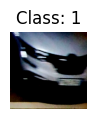

In [6]:
''' 5. 데이터 확인하기 (2) '''
pltsize = 1
plt.figure(figsize=(BATCH_SIZE * pltsize, pltsize))

for i in range(BATCH_SIZE):
    plt.subplot(1, BATCH_SIZE, i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i]))

In [7]:
''' 6. 불러온 특정 모델에 대해 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train() # 모델을 학습 상태로 지정
    for batch_idx, (image, label) in enumerate(train_loader):
        label = list(map(int, label))
        label = torch.Tensor(label)
        image = image.to(DEVICE) # 기존 정의한 장비에 할당
        label = label.to(DEVICE) # 기존 정의한 장비에 할당
        optimizer.zero_grad() # 기존 할당되어 있던 gradient 값 초기화
        output = model(image) # Forward propagation
        loss = criterion(output, label.long()) # loss 계산
        loss.backward() # Backpropagation을 통해 계산된 gradient 값을 각 파라미터에 할당
        optimizer.step() # 파라미터 업데이트
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
                  Epoch, batch_idx * len(image),
                  len(train_loader.dataset), 100. * batch_idx / len(train_loader),
                  loss.item()))

In [8]:
''' 7. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def evaluate(model, test_loader):
    model.eval() # 모델을 평가 상태로 지정
    test_loss = 0
    correct = 0
    
    with torch.no_grad(): # 평가하는 단계에서 gradient를 통해 파라미터 값이 업데이트되는 현상을 방지
        for image, label in test_loader:
            label = list(map(int, label))
            label = torch.Tensor(label)
            image = image.to(DEVICE) # 기존 정의한 장비에 할당
            label = label.to(DEVICE) # 기존 정의한 장비에 할당
            output = model(image) # Forward propagation
            test_loss += criterion(output, label.long()).item() # loss 누적
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item() 
            
    test_loss /= len(test_loader.dataset) # 평균 loss 계산
    test_accuracy = 100. * correct / len(test_loader.dataset) # 정확도 계산
    return test_loss, test_accuracy

In [9]:
import torchvision.models as models
model = models.resnet34(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model = model.cuda()

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0005)
criterion = nn.CrossEntropyLoss()

for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("\nEPOCH: {}], \tTest Loss: {:.4f}, \tTest Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/1867(0%)]	Train Loss: 0.649620
Train Epoch: 1 [200/1867(11%)]	Train Loss: 0.049933
Train Epoch: 1 [400/1867(21%)]	Train Loss: 0.741021
Train Epoch: 1 [600/1867(32%)]	Train Loss: 1.435115
Train Epoch: 1 [800/1867(43%)]	Train Loss: 0.051558
Train Epoch: 1 [1000/1867(54%)]	Train Loss: 0.081546
Train Epoch: 1 [1200/1867(64%)]	Train Loss: 1.599871
Train Epoch: 1 [1400/1867(75%)]	Train Loss: 0.096436
Train Epoch: 1 [1600/1867(86%)]	Train Loss: 0.011871
Train Epoch: 1 [1800/1867(96%)]	Train Loss: 0.090005

EPOCH: 1], 	Test Loss: 0.6479, 	Test Accuracy: 61.13 %

Train Epoch: 2 [0/1867(0%)]	Train Loss: 0.011377
Train Epoch: 2 [200/1867(11%)]	Train Loss: 0.075613
Train Epoch: 2 [400/1867(21%)]	Train Loss: 0.246117
Train Epoch: 2 [600/1867(32%)]	Train Loss: 0.025769
Train Epoch: 2 [800/1867(43%)]	Train Loss: 0.043422
Train Epoch: 2 [1000/1867(54%)]	Train Loss: 0.372807
Train Epoch: 2 [1200/1867(64%)]	Train Loss: 0.061728
Train Epoch: 2 [1400/1867(75%)]	Train Loss: 0.037590
Train